In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/project/chapter_10_utils.py')

In [2]:
!cp /content/gdrive/MyDrive/project/chapter_10_utils.py .

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!cp /content/gdrive/MyDrive/project/credit_card_default.csv .

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6, 2.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Deep Learning in Finance

## Deep Learning for Tabular Data

1. Import the libraries:

In [6]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from chapter_10_utils import performance_evaluation_report, custom_set_seed
# set seed for reproducibility
custom_set_seed(42)

ModuleNotFoundError: No module named 'fastai'

2. Load the dataset from a CSV file:

In [ ]:
df= pd.read_csv('/content/gdrive/MyDrive/project/credit_card_default.csv')
df.head()

3. Identify the dependent variable (target) and numerical/categorical features:

In [ ]:
DEP_VAR = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(DEP_VAR)
cat_features = list(df.select_dtypes('object').columns)

preprocessing = [FillMissing, Categorify, Normalize]

4. Create a `TabularDataBunch` from the DataFrame:

In [ ]:
data = (TabularList.from_df(df, 
                            cat_names=cat_features,
                            cont_names=num_features, 
                            procs=preprocessing)
                   .split_by_rand_pct(valid_pct=0.2, seed=42)
                   .label_from_df(cols=DEP_VAR)
                   .databunch())

We additionally inspect a few rows from the DataBunch:

In [ ]:
data.show_batch(rows=5)

5. Define the `Learner` object:

In [ ]:
learn = tabular_learner(data, layers=[1000,500],
                        ps=[0.001,0.01],
                        emb_drop=0.04,
                        metrics=[Recall(),
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

6. Inspect the model's architecture:

In [7]:
learn.model

NameError: name 'learn' is not defined

`Embedding(11, 6)` means that a categorical embedding was created with 11 input values and 6 output latent features.

7. Find the suggested learning rate:

In [8]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# plt.tight_layout()
plt.show()

NameError: name 'learn' is not defined

8. Train the Neural Network:

In [ ]:
learn.fit(epochs=25, lr=1e-6, wd=0.2)

9. Plot the losses:

In [ ]:
learn.recorder.plot_losses()

# plt.tight_layout()
plt.show()

10. Extract the predictions for the validation set:

In [ ]:
preds_valid, _ = learn.get_preds(ds_type=DatasetType.Valid)
pred_valid = preds_valid.argmax(dim=-1)

11. Inspect the performance (confusion matrix) on the validation set:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# plt.tight_layout()
plt.show()

In [9]:
interp.plot_tab_top_losses(5)

NameError: name 'interp' is not defined

12. Inspect the performance evaluation metrics:

In [ ]:
performance_evaluation_report(learn)

## Multilayer perceptrons for time series forecasting

1. Import the libraries:

In [10]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset)

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'torch'

2. Define parameters:

In [ ]:
# data
TICKER = 'ANF'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
N_LAGS = 3

# neural network 
VALID_SIZE = 12
BATCH_SIZE = 5
N_EPOCHS = 1000

3. Download and prepare the data:

In [ ]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('M').last()
prices = df['Adj Close'].values

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Define a function for transforming time series into a dataset for the MLP:

In [ ]:
def create_input_data(series, n_lags=1):
  '''
  Function for transforming time series into input acceptable by a multilayer perceptron.

  Parameters
  ----------
  series : np.array
  The time series to be transformed
  n_lags : int
  The number of lagged observations to consider as features

  Returns
  -------
  X : np.array
  Array of features
  y : np.array
  Array of target
  '''
  X, y = [], []

  for step in range(len(series) - n_lags):
    end_step = step + n_lags
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

5. Transform the considered time series into input for the MLP:

In [ ]:
X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

6. Create training and validation sets:

In [ ]:
valid_ind = len(X) - VALID_SIZE
dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Inspect the observations from the first batch:

In [ ]:
next(iter(train_loader))[0]

In [ ]:
next(iter(train_loader))[1]

Check the size of the datasets:

In [12]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

NameError: name 'train_loader' is not defined

7. Use naive forecast as a benchmark and evaluate the performance:

In [13]:
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

NameError: name 'prices' is not defined

In [14]:
# BONUS: Testing Linear Regression

# from sklearn.linear_model import LinearRegression

# X_train = X[:valid_ind, ]
# y_train = y[:valid_ind]

# X_valid = X[valid_ind:, ]
# y_valid = y[valid_ind:]

# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)

# y_pred = lin_reg.predict(X_valid)
# lr_mse = mean_squared_error(y_valid, y_pred)
# lr_rmse = np.sqrt(lr_mse)
# print(f"Linear Regression's forecast - MSE: {lr_mse:.2f}, RMSE: {lr_rmse:.2f}")
# print(f"Linear Regression's coefficients: {lin_reg.coef_}")

# fig, ax = plt.subplots()

# ax.plot(y_valid, color='blue', label='Actual')
# ax.plot(y_pred, color='red', label='Prediction')

# ax.set(title="Linear Regression's Forecasts", 
#        xlabel='Time', 
#        ylabel='Price ($)')
# ax.legend();

8. Define the network's architecture:

In [15]:
class MLP(nn.Module):

  def __init__(self, input_size):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_size, 8)
    self.linear2 = nn.Linear(8, 4)
    self.linear3 = nn.Linear(4, 1)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    return x

NameError: name 'nn' is not defined

9. Instantiate the model, the loss function and the optimizer:

In [ ]:
# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
model

NameError: name 'model' is not defined

10. Train the network:

In [ ]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():

        model.eval()

        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')

11. Plot the losses over epochs:

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs', 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

12. Load the best model (with the lowest validation loss):

In [ ]:
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

13. Obtain the predictions:

In [ ]:
y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)

y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

14. Evaluate the predictions:

In [ ]:
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label= 'True')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="Multilayer Perceptron's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

## Convolutional neural networks for time series forecasting

1. Import the libraries:

In [17]:
import yfinance as yf
import numpy as np
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed
from sklearn.metrics import mean_squared_error
print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'torch'

2. Define the parameters:

In [18]:
# data
TICKER = 'INTC'
START_DATE = '2015-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 5
N_EPOCHS = 2000

3. Download and prepare the data:

In [19]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values

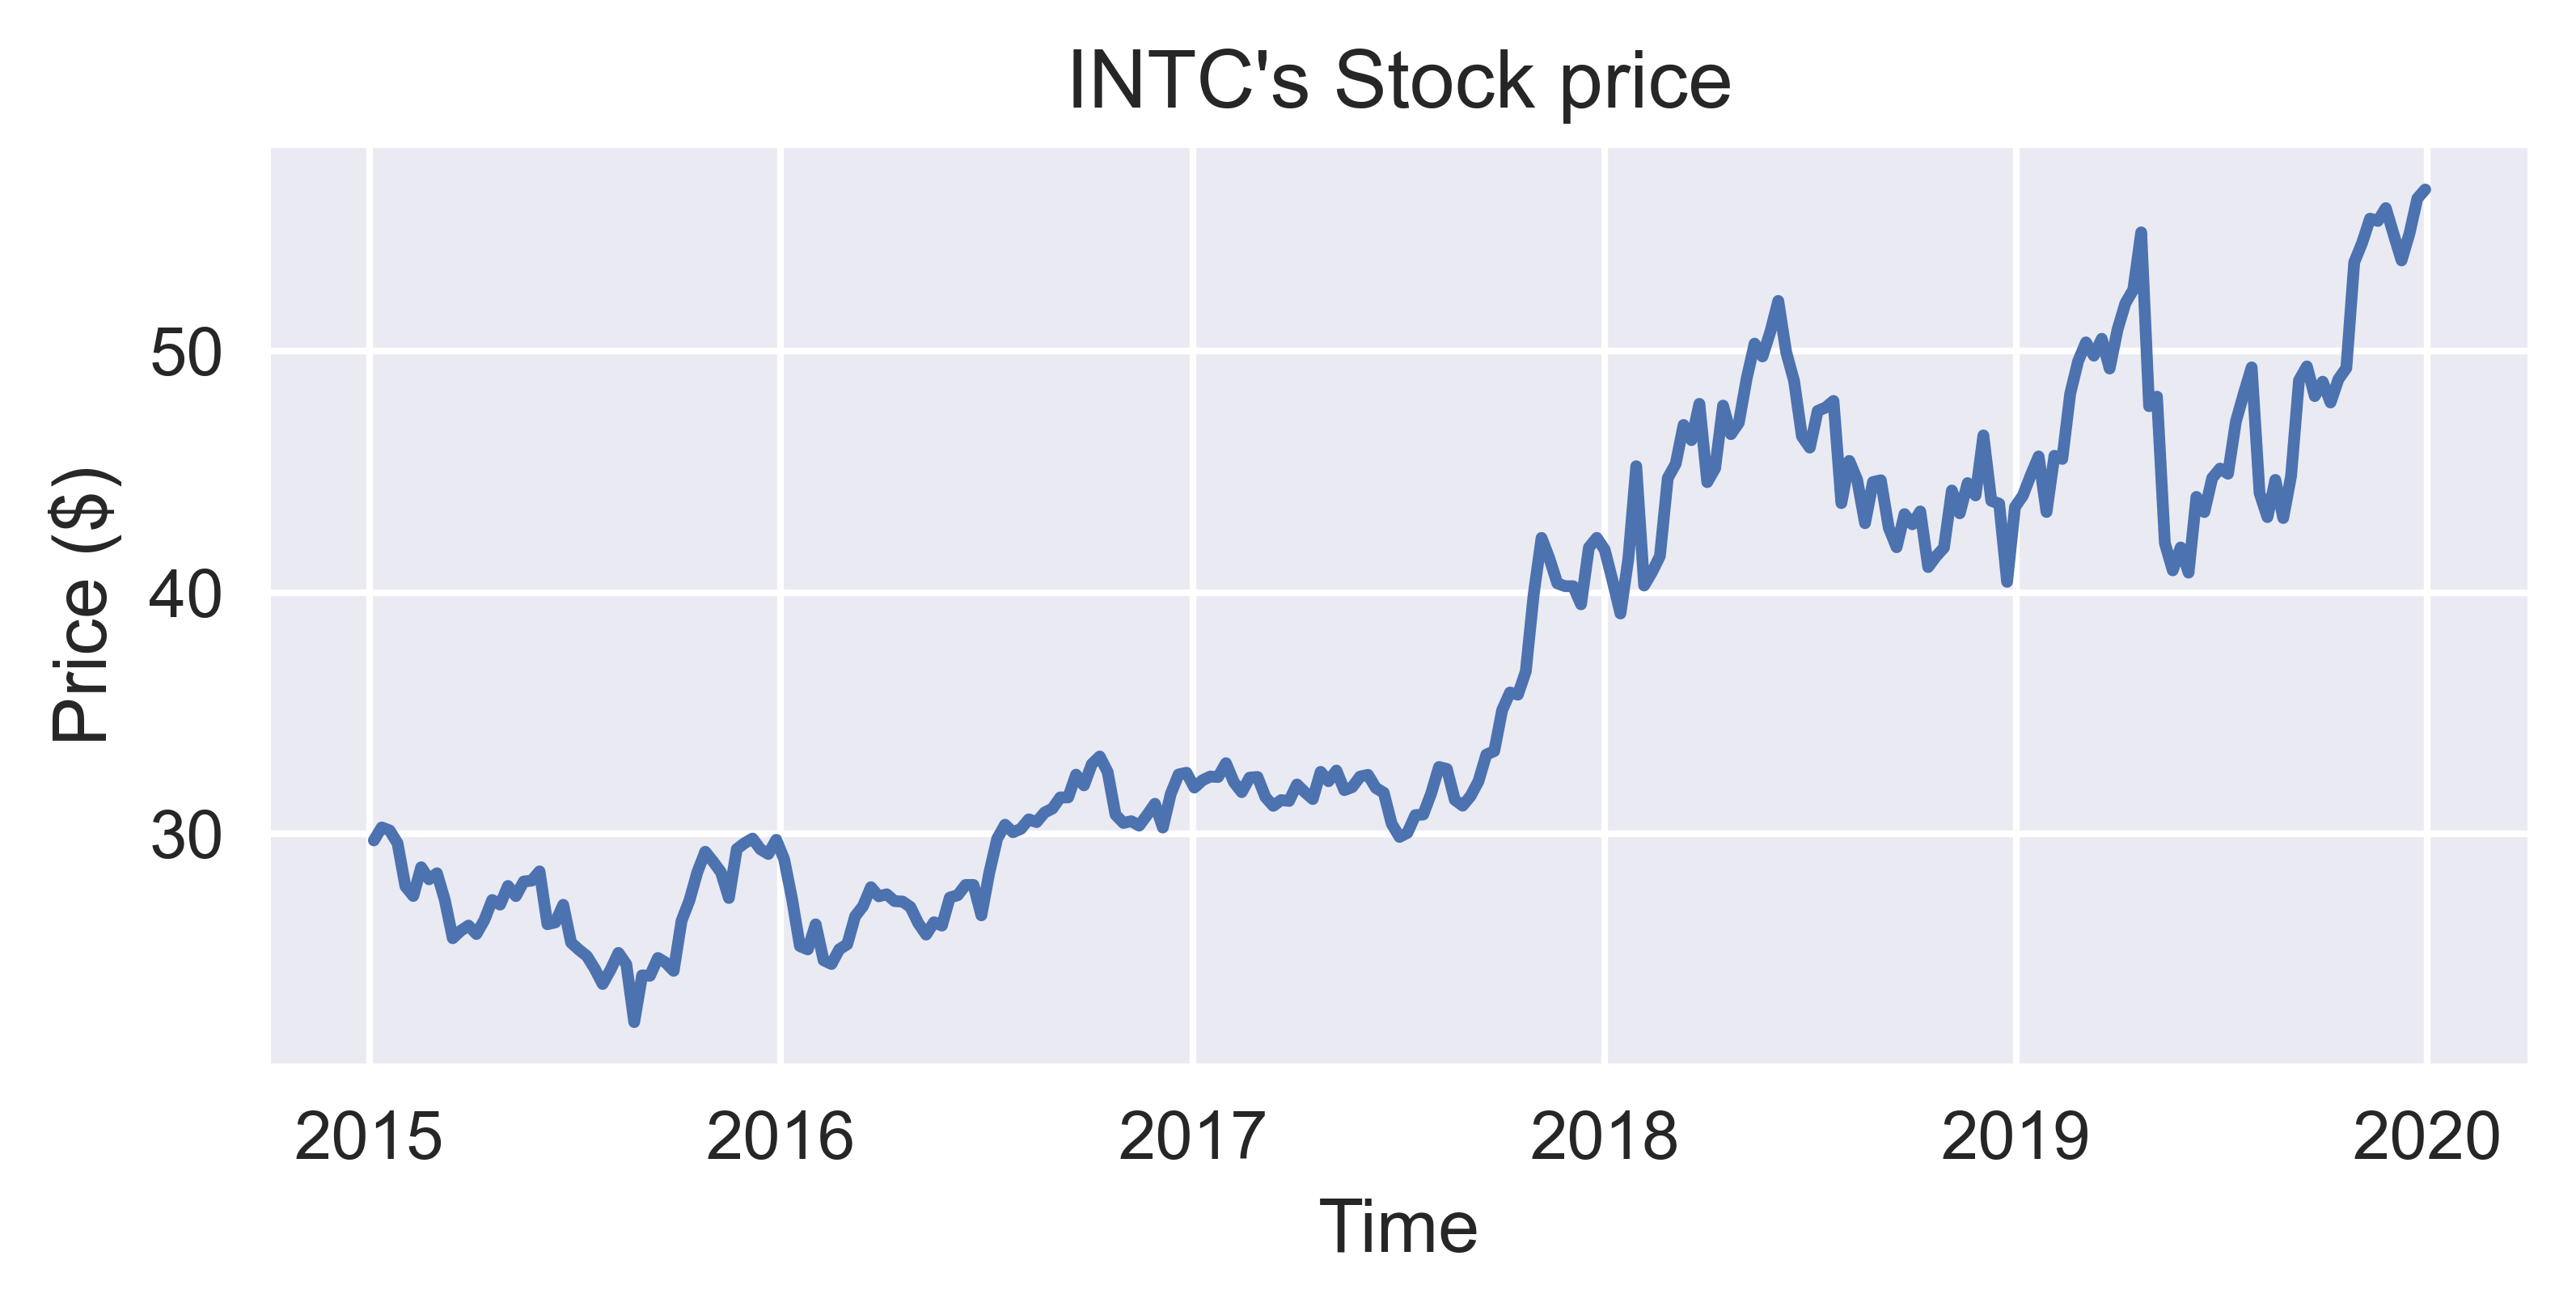

In [20]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Transform the time series into input for the CNN:

In [21]:
X, y = create_input_data(prices, N_LAGS)

NameError: name 'create_input_data' is not defined

5. Obtain the naïve forecast:

In [ ]:
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

6. Prepare the `DataLoader` objects:

In [ ]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Check the size of the datasets:

In [ ]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

7. Define the CNN's architecture:

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
      return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

8. Instantiate the model, the loss function and the optimizer:

In [ ]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

9. Train the network:

In [22]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
           best_epoch = epoch
           torch.save(model.state_dict(), './cnn_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')


NameError: name 'model' is not defined

10. Plot the losses over epochs:

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

11. Load the best model (with the lowest validation loss):

In [ ]:
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

12. Obtain the predictions:

In [ ]:
y_pred, y_valid = [], []

with torch.no_grad():

    model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)

y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

13. Evaluate the predictions:

In [23]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')
#ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="CNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

NameError: name 'mean_squared_error' is not defined

## Recurrent neural networks for time series forecasting

1. Import the libraries:

In [ ]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2. Define the parameters:

In [ ]:
# data
TICKER = 'INTC'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 16
N_EPOCHS = 100

3. Download and prepare the data:

In [ ]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values.reshape(-1, 1)

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Scale the time series of prices:

In [ ]:
valid_ind = len(prices) - valid_size
minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()
#plt.plot(prices_scaled)


5. Transform the time series into input for the RNN:

In [24]:
X, y = create_input_data(prices_scaled, N_LAGS)

NameError: name 'create_input_data' is not defined

6. Obtain the naïve forecast:

In [ ]:
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

7. Prepare the `DataLoader` objects:

In [25]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], 
                                               X.shape[1], 
                                               1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

NameError: name 'custom_set_seed' is not defined

Check the size of the datasets:

In [ ]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

8. Define the model:

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers, output_size):
      super(RNN, self).__init__()
      self.rnn = nn.RNN(input_size, hidden_size, 
                        n_layers, batch_first=True,
                        nonlinearity='relu')
      self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
      output, _ = self.rnn(x)
      output = self.fc(output[:,-1,:]) 
      return output

9. Instantiate the model, the loss function and the optimizer:

In [ ]:
model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

10. Train the network:

In [ ]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './rnn_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

        if epoch % PRINT_EVERY == 0:
            print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')



11. Plot the losses over epochs:

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

12. Load the best model (with the lowest validation loss):

In [26]:
state_dict = torch.load('rnn_checkpoint.pth')
model.load_state_dict(state_dict)

NameError: name 'torch' is not defined

13. Obtain the predictions:

In [27]:
y_pred = []

with torch.no_grad():

    model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)

y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten()

NameError: name 'torch' is not defined

14. Evaluate the predictions:

In [ ]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
print(f"RNN's forecast - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='RNN')
ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="RNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()